In [182]:
import pandas as pd
import seaborn as sns
import numpy as np
import math
from matplotlib import pyplot as plt
import csv
from scipy.stats import norm, binom, ks_2samp
from scipy import stats, linalg
import random
from decimal import Decimal
import pydtmc
from collections import Counter
import quantecon as qe
from mpl_toolkits.mplot3d import Axes3D
from random import randint
from tqdm.auto import tqdm
from statsmodels.graphics.tsaplots import plot_acf

In [183]:
from ipynb.fs.full.BoringTM import *

In [184]:
## Base parameters
"""
LC = 1 ## Lobby Cost
T = 10 ## Tax
mF = 10 ## Mean Fee of Getting Caught
nPPL = 11
fR = .25
R = nPPL * fR # enforcement resources

LobH = [2] ## Lobby History, arbitrary preset
CatH = [1] ## Catch history, arbitrary preset
"""

'\nLC = 1 ## Lobby Cost\nT = 10 ## Tax\nmF = 10 ## Mean Fee of Getting Caught\nnPPL = 11\nfR = .25\nR = nPPL * fR # enforcement resources\n\nLobH = [2] ## Lobby History, arbitrary preset\nCatH = [1] ## Catch history, arbitrary preset\n'

In [185]:
def pSS1(LobH, CatH, nPPL, fR): #Gets probability of lobbying successfully, subjective
    t = len(LobH) - 1
    pss = 1 - ((.8+CatH[t]) / (1+LobH[t]))
    return pss

In [186]:
def pCat(LobH, nPPL, fR):  #Gets objective probability of success 
    R = nPPL * fR
    t = len(LobH) - 1
    if LobH[t] <= R:
        return .8
    else:
        return .8 * (R / LobH[t])

In [187]:
def it(LobH, CatH, LC, T, mF, nPPL, fR, fines, subj):
    t = len(LobH)
    ps = pSS1(nPPL = nPPL, fR = fR, LobH = LobH, CatH = CatH)
    subj[0].append(ps)
    LobH.append(0)
    CatH.append(0)
    fines.append(0)
    for i in range(0,nPPL+1):
        ifine = np.random.normal(loc = mF, scale = 1)
        if -T < (ps * -LC) + ((1-ps) * (-T - LC - (ifine))):
            LobH[t] = LobH[t] + 1
            fines[t] = fines[t] + ifine
            
    pc = pCat(nPPL = nPPL, fR = fR, LobH = LobH)
    subj[1].append(pc)      
    for i in range(0,LobH[t]):

        if random.random() < pc:
            CatH[t] = CatH[t] + 1
            
    
    else:
        return LobH, CatH, fines, subj

In [188]:
def run(itr, LobH, CatH, LC, T, mF, nPPL, fR, fines, subj):
    for i in tqdm(range(0,itr)):
        LobH, CatH, fines, subj = it(LobH = LobH, CatH = CatH, LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, fines = fines, subj = subj)
    return LobH, CatH, fines, subj

In [189]:
def set(LC, T, mF, nPPL, fR, itr, fines = [], sp = False):
    LobH = [randint(0,nPPL)] ## Lobby History, arbitrary preset
    CatH = [randint(0,LobH[0])] ## Catch history, arbitrary preset
    fines = [CatH[0] * mF]
    subj = [[.2], [.8]]
    LobH, CatH, fines, subj = run(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr, LobH = LobH, CatH = CatH, fines = fines, subj = subj)
    if sp == True:
        return LobH, CatH, fines, subj
    else:
        return LobH, CatH, fines

In [190]:
LobH, CatH, fines, subj = set(fR = .5, LC = 1, T = 5, mF = 2, nPPL = 10, itr = 50, sp = True)


100%|██████████| 50/50 [00:00<?, ?it/s]


Text(0, 0.5, 'nL & nC')

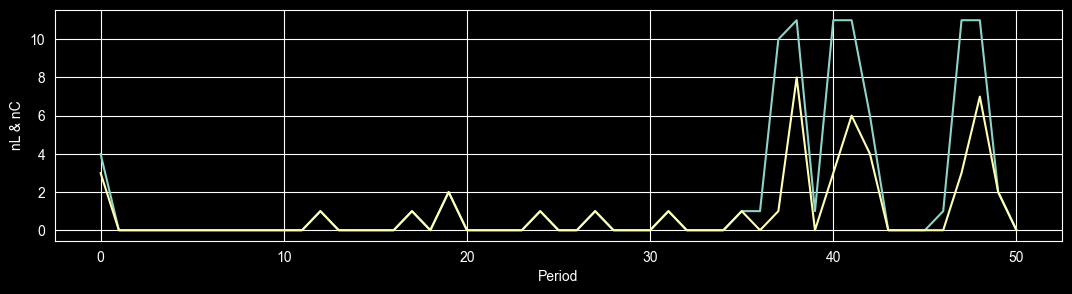

In [191]:
plt.style.use('dark_background')
plt.figure(figsize=(13, 3)) 
plt.plot(LobH)
plt.plot(CatH)
plt.xlabel("Period")
plt.ylabel("nL & nC")

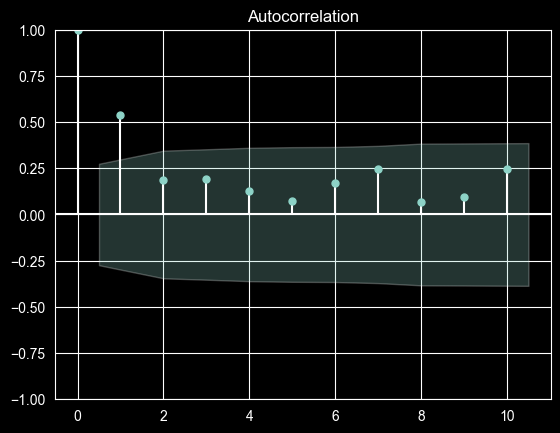

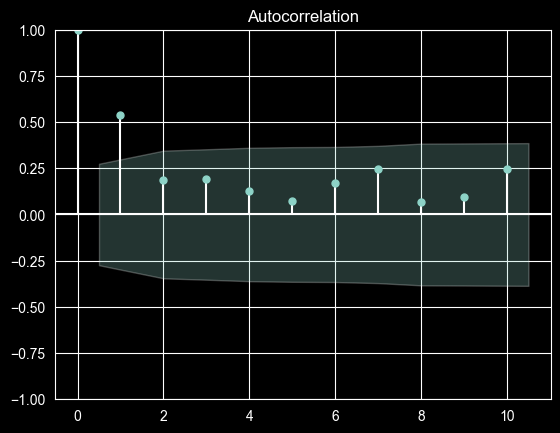

In [192]:
plot_acf(LobH, lags=10)

Text(0, 0.5, 'Probability of Success')

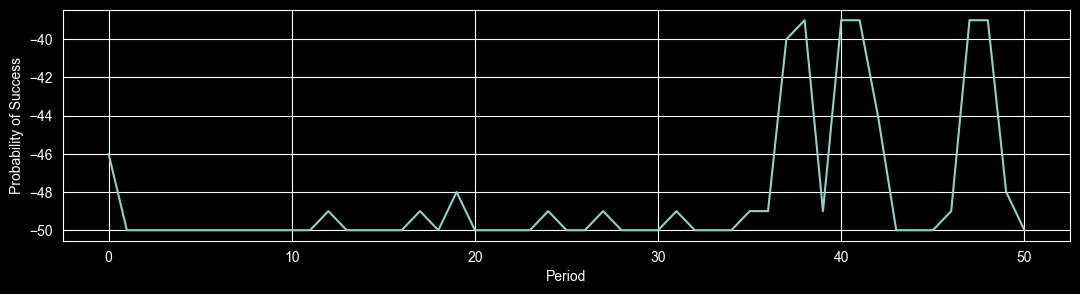

In [193]:
plt.figure(figsize=(13, 3)) 
plt.plot([x - .5*100 for x in LobH])
plt.xlabel("Period")
plt.ylabel("Probability of Success")

Text(0.5, 0, 'Period')

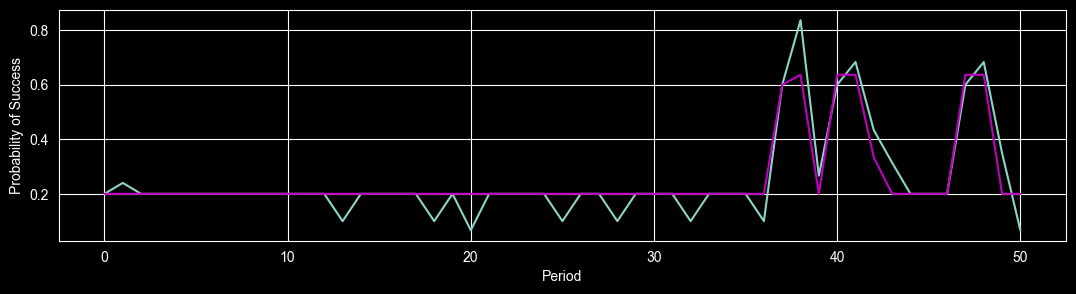

In [194]:
plt.figure(figsize=(13, 3)) 
plt.plot(subj[0], )
plt.plot([1 - x for x in subj[1]], 'm')
plt.ylabel("Probability of Success")
plt.xlabel("Period")

Text(0, 0.5, 'Fines Collected')

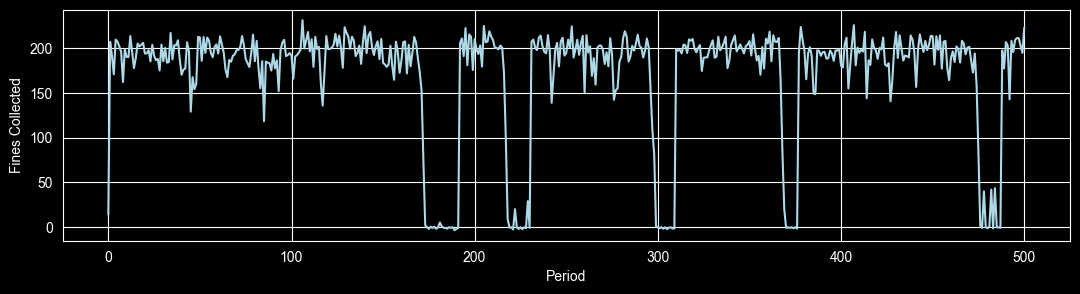

In [246]:
plt.figure(figsize=(13, 3)) 
plt.plot(fines, 'lightblue')
plt.xlabel("Period")
plt.ylabel("Fines Collected")

In [196]:
def itrFines(LC, T, nPPL, itr, fR, bl):
    mF = bl
    fines = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)[2]
    TF = [sum(fines) / len(fines)]
    for i in range(2,int(10+1)):
        mF = i * bl
        fines = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)[2]
        TF.append(sum(fines) / len(fines))
    return TF


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:01<00:00, 5555.97it/s]


Text(0, 0.5, 'Average Fine Collected')

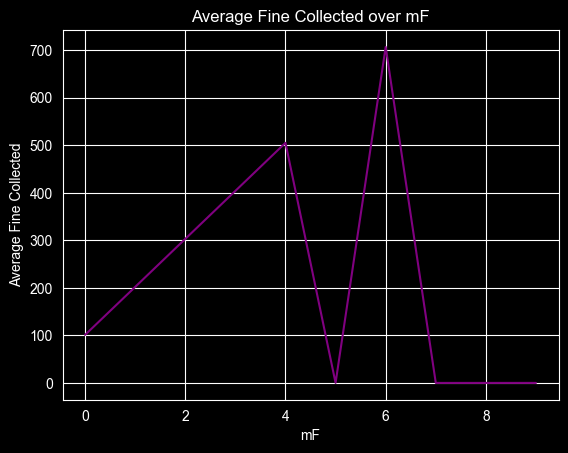

In [197]:
plt.plot(itrFines(LC = 1, T = 5, fR = .2, nPPL = 100, itr = 10000, bl = 1), color = 'purple')
plt.title("Average Fine Collected over mF")
plt.xlabel("mF")
plt.ylabel("Average Fine Collected")

In [198]:
def itrLB(LC, T, nPPL, itr, fR, bl):
    mF = bl
    LobH, CatH, fines = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
    LB = [( sum(LobH) * (T - LC) ) - ( sum(fines) / len(fines) )]
    for i in range(2,int(10+1)):
        mF = i * bl
        LobH, CatH, fines = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
        LB.append(( sum(LobH) * (T - LC) ) - ( sum(fines) / len(fines) ))
    return LB
LobH, CatH, fines, subj = set(fR = .5, LC = 1, T = 5, mF = 2, nPPL = 100, itr = 500, sp = True)


100%|██████████| 500/500 [00:00<00:00, 4188.21it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:02<00:00, 3396.93it/s]


Text(0, 0.5, 'Average Benafit to Lobbying')

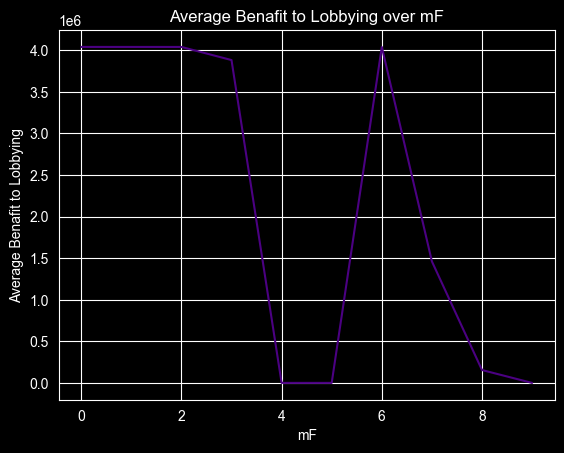

In [199]:
plt.plot(itrLB(LC = 1, T = 5, fR = .2, nPPL = 100, itr = 10000, bl = 1), color = 'indigo')
plt.title("Average Benafit to Lobbying over mF")
plt.xlabel("mF")
plt.ylabel("Average Benafit to Lobbying")

In [200]:
def itrEF(LC, T, mF, nPPL, itr, bl):
    fR = 1 * bl
    EF = [(fR *nPPL) - (sum(set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)[0])/itr)]
    for i in range(2,int((1/bl)+1)):
        fR = i * bl
        EF.append((fR *nPPL) - (sum(set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)[0])/itr))
    return EF

 20%|██        | 202/1000 [00:00<00:00, 1886.83it/s]

100%|██████████| 1000/1000 [00:00<00:00, 3803.88it/s]


Text(0, 0.5, 'Average Excess Capacity of R')

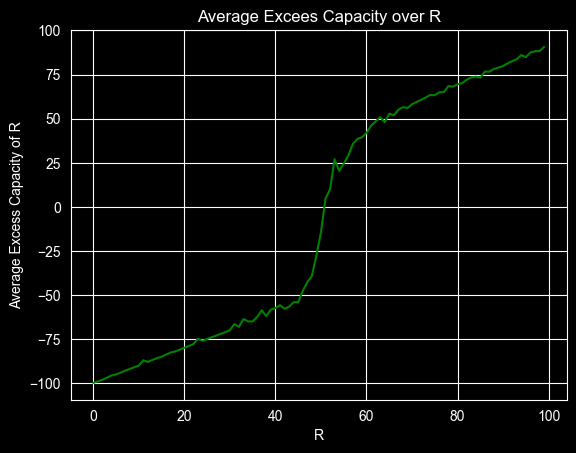

In [201]:
plt.plot(itrEF(LC = 1, T = 5, mF = 2, nPPL = 100, itr = 1000, bl = .01), color = 'green')
plt.title("Average Excees Capacity over R")
plt.xlabel("R")
plt.ylabel("Average Excess Capacity of R")

In [202]:
def DynPDF(LC, T, mF, nPPL, fR, itr):
    MAXitr = itr
    itr = 10
    LobH, CatH, fines = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
    count, bins_count = np.histogram(LobH, bins=nPPL+1)
    pdf2 = count / sum(count) 
    diff = 1

    while diff > .01 and itr <= MAXitr:
        itr = itr * 10
        pdf = pdf2
        LobH, CatH, fines = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
        count, bins_count = np.histogram(LobH, bins=nPPL+1)
        pdf2 = count / sum(count)
        diff = sum(abs(pdf - pdf2)) 
        n = 0
        while diff < .0001 and n < 4:
            n = n + 1
            LobH, CatH, fines = set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
            count, bins_count = np.histogram(LobH, bins=nPPL+1)
            pdf2 = count / sum(count)
            diff = sum(abs(pdf - pdf2))
        #if itr >= MAXitr: break
    #cdf = np.cumsum(pdf) 
    #nL = range(0,nPPL+1) # equals to list(set(words))
    #Lfreq = [x/(len(LobH)) for x in list(Counter(LobH).values())] # counts the elements' frequency
    pdf = pdf2   
    print(f"Stationary at {itr} iterations")
    return pdf, bins_count

In [203]:
DynPDF(fR = .5, LC = 1, T = 15, mF = 5, nPPL = 10, itr = 100000)[0]

100%|██████████| 1000000/1000000 [00:16<00:00, 62450.81it/s]


Stationary at 1000000 iterations


array([4.87466513e-01, 3.30099670e-02, 2.87599712e-03, 1.39599860e-03,
       7.46999253e-04, 3.71999628e-04, 2.67999732e-04, 2.77999722e-04,
       6.70999329e-04, 2.63599736e-03, 4.70279530e-01])

In [204]:
DPDF = DynPDF(fR = .5, LC = 1, T = 15, mF = 5, nPPL = 30, itr = 1000)[0]
pBin = 0
for i in range(0,5+1):
    pBin = pBin + DPDF[i]
pBin

100%|██████████| 10000/10000 [00:00<00:00, 23286.75it/s]

Stationary at 10000 iterations


0.0141985801419858

In [205]:
def ConvTEST(LC, T, mF, nPPL, fR, itr):
       DPDF = DynPDF(fR = fR, LC = LC, T = T, mF = mF, nPPL = nPPL, itr = itr)[0]
       TMPDF = CollapsedSD(fR = fR, LC = LC, T = T, mF = mF, nPPL = nPPL)
       
       #plt.plot(DPDF, color="red", label="PDF")
       #plt.plot(TMPDF, color="green", label="SD")
       #plt.ylim([0, 1])
       
       print(DPDF)
       print(TMPDF)
       diff = sum(abs(DPDF - TMPDF))
       print(f"Differnece is : {diff}")
       if diff < .01: print("Yay")
       else: print("sucks to suck")

In [206]:
ConvTEST(LC = 1, T = 5, mF = 5, nPPL = 10, fR = .5, itr = 1000000)

100%|██████████| 10000/10000 [00:00<00:00, 69621.59it/s]


Stationary at 10000 iterations


100%|██████████| 66/66 [00:04<00:00, 15.65it/s]

[9.9990001e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 9.9990001e-05]
[9.99996479e-01 2.88867968e-06 3.36884411e-08 7.30602598e-08
 1.22696851e-07 1.45770119e-07 1.21432701e-07 7.02326260e-08
 2.86898498e-08 1.16675384e-08 2.47432650e-08]
Differnece is : 0.00019993051546987617
Yay


In [207]:
TMPDF = [.1,.2,.3,.2,.1,.1]
TMPDF2 = [.3,.2,.2,.1,.1,.1]
cdf = np.cumsum(TMPDF)
cdf
#stats.kstest(TMPDF, TMPDF2)
ks_2samp(TMPDF, TMPDF2)

KstestResult(statistic=0.0, pvalue=1.0, statistic_location=0.1, statistic_sign=1)

In [208]:
def GraphDynPDF(LC, T, mF, nPPL, fR, itr):
    pdf, bins_count = DynPDF(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
    #plt.plot(bins_count[1:], pdf, color="red", label="PDF")
    plt.plot(pdf, color = 'orange')
    plt.ylim([0, 1])
    plt.xlabel("nL")
    plt.ylabel("Probability")
    plt.title("Probability Density Function")
    plt.xlim(0,nPPL)

100%|██████████| 10000/10000 [00:00<00:00, 62148.61it/s]


Stationary at 10000 iterations


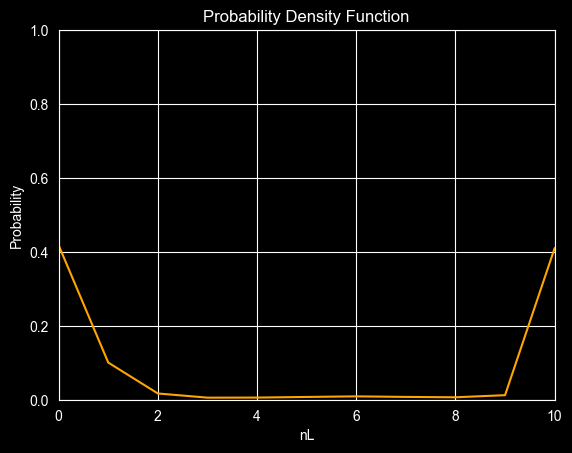

In [209]:
GraphDynPDF(fR = .4, LC = 1, T = 5, mF = 2, nPPL = 10, itr = 1000)

In [210]:
def DynItrR(LC, T, mF, nPPL, itr, bl):
    fR = 1 * bl
    RDis = DynPDF(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)[0]
    for i in range(2,int(1/bl+1)):
        fR = i * bl
        tRDis = DynPDF(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)[0]
        RDis = np.vstack([RDis, tRDis])
    return RDis

In [211]:
def GraphDynROut(LC, T, mF, nPPL, bl, itr):
    
    sns.set_style ("darkgrid")
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)

    x = range(0,nPPL+1)
    y = range(0,int(1/bl))

    data = DynItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, itr = itr, bl = bl)

    hf = plt.figure()
    ha = hf.add_subplot(projection='3d')

    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    ha.plot_surface(X, Y, data)

    ha.set_xlabel('nLobby')
    ha.set_ylabel('R')
    ha.set_zlabel('Probability')
    ha.set_title("3D Dynamic Disrobutions based on R")

    plt.show()

100%|██████████| 10000/10000 [00:00<00:00, 62796.69it/s]


Stationary at 10000 iterations


100%|██████████| 10000/10000 [00:00<00:00, 60139.34it/s]


Stationary at 10000 iterations


100%|██████████| 10000/10000 [00:00<00:00, 60365.59it/s]


Stationary at 10000 iterations


100%|██████████| 10000/10000 [00:00<00:00, 60941.31it/s]


Stationary at 10000 iterations


100%|██████████| 10000/10000 [00:00<00:00, 61309.48it/s]


Stationary at 10000 iterations


100%|██████████| 10000/10000 [00:00<00:00, 66164.56it/s]


Stationary at 10000 iterations


100%|██████████| 10000/10000 [00:00<00:00, 61600.86it/s]


Stationary at 10000 iterations


100%|██████████| 10000/10000 [00:00<00:00, 61357.19it/s]


Stationary at 10000 iterations


100%|██████████| 10000/10000 [00:00<00:00, 67395.92it/s]


Stationary at 10000 iterations


100%|██████████| 10000/10000 [00:00<00:00, 67177.65it/s]


Stationary at 10000 iterations


<Figure size 1000x1000 with 0 Axes>

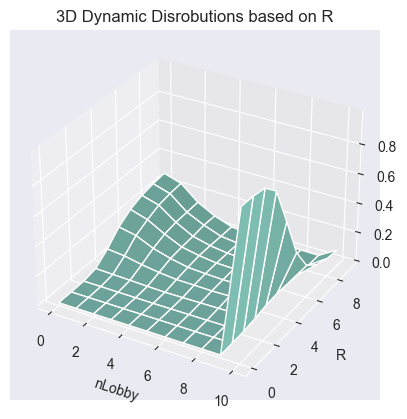

In [212]:
GraphDynROut(LC = 1, T = 5, mF = 1, nPPL = 10, bl = .1, itr = 1000)

In [213]:
def sc(nL, nC, nPPL, fR, T, fines):
    return (0 - (10 * (nPPL * fR)) + ((2 - 1) * ((T * (nPPL - nL)) + ((fines + T) * nC)) )) #- (T * (nPPL - nL))

In [214]:
def asc(fR, LC, T, mF, nPPL, itr):
    LobH, CatH, fines= set(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)
    cost = sc(nL = sum(LobH) / len(LobH), nC = sum(CatH) / len(CatH), fines = sum(fines) / len(fines), T = T, nPPL = nPPL, fR = fR)
    return cost

In [215]:
def CostItrR(LC, T, mF, nPPL, itr, bl):
    fR = 1 * bl
    listcost = [asc(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)]
    for i in range(2,int((1/bl)+1)):
        fR = i * bl
        listcost.append(asc(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr))
    return listcost

In [216]:
def MFItr(LC, T, nPPL, itr, step, bl):
    mF = step
    listMF = [CostItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, bl = bl, itr = itr)]
    for i in range(2,int(10+1)):
        mF = i * step
        listMF.append(CostItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, bl = bl, itr = itr))
    return listMF

In [217]:
def TItr(LC, mF, nPPL, itr, step, bl):
    T = step
    listT = [CostItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, bl = bl, itr = itr)]
    for i in range(2,int(10+1)):
        T = i * step
        listT.append(CostItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, bl = bl, itr = itr))
    return listT

In [252]:
def GraphMFitr(LC, T, nPPL, bl, step, itr):
    
    sns.set_style("darkgrid")
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)

    x = range(1,int(1/bl)+1)
    y = range(1,10+1)

    data = MFItr(LC = LC, T = T, nPPL = nPPL, itr = itr, bl = bl, step = step)
    maxMF = data.index(max(data))
    maxR = data[maxMF].index(max(data[maxMF]))
    data = np.array(data)
    print(data)

    hf = plt.figure()
    ha = hf.add_subplot(projection='3d')

    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    ha.plot_surface(X, Y, data)
    print(data)
    ha.set_xlabel('R')
    ha.set_ylabel('mF')
    ha.set_zlabel('Average Social Benafit')
    ha.set_title(f"Maximum Avg. Social Benafit: mf = {(maxMF+1)*step:.2f}, R = {(maxR+1)*(100*bl)}%")

    plt.show()

In [249]:
def GraphTitr(LC, mF, nPPL, bl, step, itr):
    
    sns.set_style("darkgrid")
    fig = plt.figure(figsize=(10,10))
    ax = Axes3D(fig)

    x = range(1,10+1)
    y = range(1,10+1)

    data = TItr(LC = LC, mF = mF, nPPL = nPPL, itr = itr, bl = bl, step = step)
    maxT = data.index(max(data))
    maxR = data[maxT].index(max(data[maxT]))
    data = np.array(data)
    print(data)

    hf = plt.figure()
    ha = hf.add_subplot(projection='3d')

    X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
    ha.plot_surface(X, Y, data)

    ha.set_xlabel('R')
    ha.set_ylabel('T')
    ha.set_zlabel('Average Social Benafit')
    ha.set_title(f"Maximum Avg. Social Benafit: T = {(maxT+1)*step:.2f}, R = {(maxR+1)*(100*bl)}%")

    plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 4402.90it/s]

[[ 3.42392019e+02  6.69043023e+02  1.00759519e+03  1.35918783e+03
   1.69273688e+03  1.47190500e+03 -6.52627691e+02 -7.59108667e+02
  -8.59126853e+02 -9.62542402e+02]
 [ 7.50873684e+02  1.47185034e+03  2.25428085e+03  2.98871669e+03
   3.67400753e+03  6.21482096e+02 -1.95973595e+02 -3.31455195e+02
  -4.27925315e+02 -5.45288499e+02]
 [ 1.13764085e+03  2.26593402e+03  3.41690117e+03  4.60217567e+03
   5.52042118e+03  3.04631119e+02 -5.04812049e+01 -2.18962081e+02
  -3.01414360e+02 -3.73728827e+02]
 [ 1.54260518e+03  3.11005846e+03  4.68988522e+03  6.15808602e+03
   3.77123271e+03  2.06500387e+02 -6.08157185e+01 -1.75706174e+02
  -3.13153576e+02 -4.09168753e+02]
 [ 1.95866960e+03  3.85661998e+03  5.90543587e+03  7.80098409e+03
   1.18044532e+03  4.05113241e+00 -1.36530631e+02 -2.27926137e+02
  -3.39926292e+02 -4.30000151e+02]
 [ 2.30183824e+03  4.73019648e+03  6.60423149e+03  9.33264651e+03
   6.09833155e+01 -9.13955623e+01 -1.90453086e+02 -2.94005727e+02
  -3.93526671e+02 -4.87360358e+02

<Figure size 1000x1000 with 0 Axes>

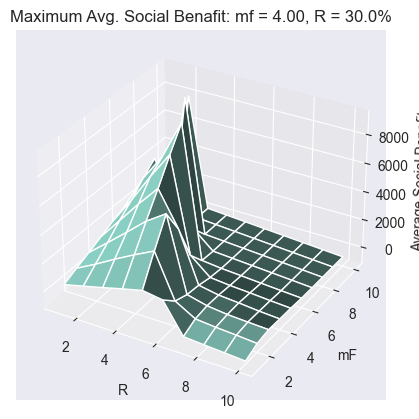

In [253]:
GraphMFitr(LC = 1, T = 5, nPPL = 100, bl = .1, step = .5, itr = 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9423.41it/s]

[[-5.99240919e-02 -1.00006095e+02 -1.99993928e+02 -3.00000918e+02
  -3.99995955e+02 -5.00021536e+02 -6.00021066e+02 -7.00002790e+02
  -8.00009057e+02 -9.00007978e+02]
 [ 9.98995430e+01 -7.96307470e-03 -1.00032030e+02 -2.00021523e+02
  -3.00244406e+02 -4.00064250e+02 -5.00136000e+02 -6.00029107e+02
  -7.00017868e+02 -8.00057160e+02]
 [ 1.99971603e+02  2.14234508e+03 -9.29787610e-01 -1.00157148e+02
  -2.00247196e+02 -2.99999900e+02 -4.00028922e+02 -5.00182476e+02
  -6.00060560e+02 -7.00002598e+02]
 [ 3.13168373e+03  6.32517155e+03  1.11705217e+02 -6.14410564e-02
  -1.00013163e+02 -2.00374796e+02 -3.00426364e+02 -4.00158109e+02
  -5.00140305e+02 -6.00068798e+02]
 [ 3.11790619e+03  3.00010668e+02  9.52196705e+03  1.53351455e+02
  -2.86552712e-01 -1.00274657e+02 -2.00253794e+02 -3.00376530e+02
  -4.00192828e+02 -5.00047620e+02]
 [ 3.20449760e+03  6.41108918e+03  9.53788494e+03  1.84979774e+03
   1.53343287e+02 -4.73573169e-01 -1.00521941e+02 -2.00256601e+02
  -3.00117038e+02 -4.00483943e+02

<Figure size 1000x1000 with 0 Axes>

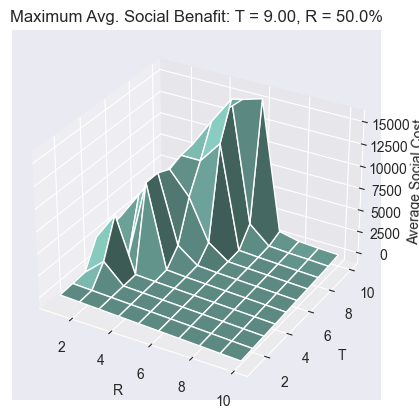

In [221]:
## We discover that the optimal level of T is always equal to the mF
GraphTitr(LC = 1, mF = 4, nPPL = 100, bl = .1, step = 1, itr = 1000)

In [222]:
def plotAvgSC(LC, mF, nPPL, bl, itr, T):
    plt.style.use('dark_background')
    listcost = CostItrR(LC = LC, T = T, mF = mF, nPPL = nPPL, bl = bl, itr = itr)
    plt.plot(range(int(100*bl),101, int(100*bl)), listcost)
    #plt.plot(listcost)
    #plt.ylim(bottom = 0)
    plt.ylabel("Average Social Benafit")
    plt.xlabel("fR")
    maxLoc = (listcost.index(max(listcost))+1)
    plt.title(f"The maximum avg. social benafit ({max(listcost) / nPPL:.2f}) accures at R = {maxLoc*(100*bl)}%, ER = {itrEF(LC = LC, T = T, mF = mF, nPPL = nPPL, itr = itr, bl = bl)[maxLoc-1]:.2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 8558.56it/s]


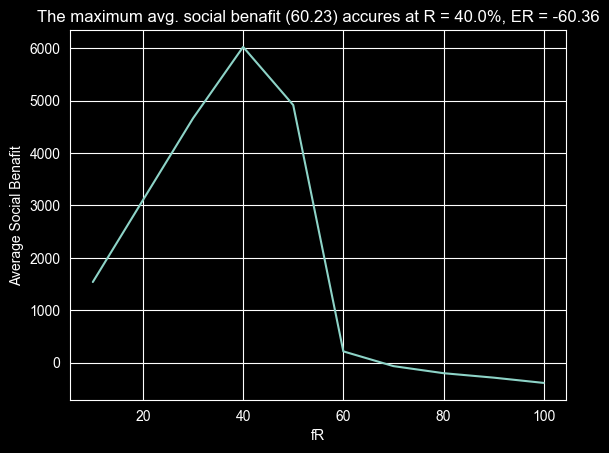

In [223]:
plotAvgSC(bl = .1, LC = 1, T = 5, mF = 2, nPPL = 100, itr = 1000)

In [224]:
def CostItrMF(LC, T, nPPL, itr, bl, fR):
    mF = 1 * bl
    listcost = [asc(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr)]
    for i in range(2,int(10+1)):
        mF = i * bl
        listcost.append(asc(LC = LC, T = T, mF = mF, nPPL = nPPL, fR = fR, itr = itr))
    return listcost

In [225]:
def plotAvgSCMF(LC, nPPL, bl, itr, T, fR):
    plt.style.use('dark_background')
    listcost = CostItrMF(LC = LC, T = T, fR = fR, nPPL = nPPL, bl = bl, itr = itr)
    #plt.plot(range(int(100*bl),101, int(100*bl)), listcost)
    plt.plot(listcost)
    #plt.ylim(bottom = 0)
    plt.ylabel("Average Social Benafit")
    plt.xlabel("mF")
    maxLoc = (listcost.index(max(listcost))+1)
    plt.title(f"The maximum avg. social benafit ({max(listcost) / nPPL:.2f}) accures at mF = {maxLoc*(bl)}%")

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:01<00:00, 9083.70it/s]


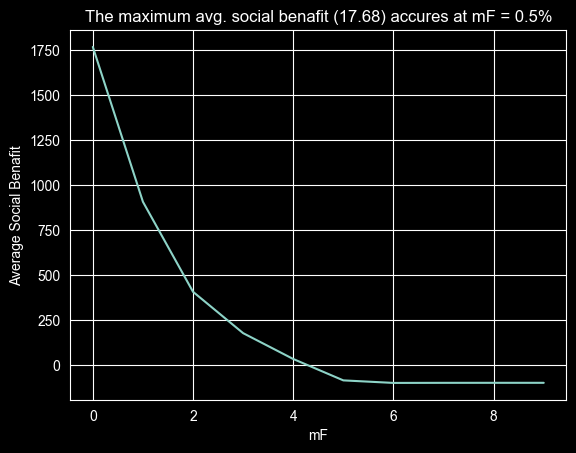

In [226]:
plotAvgSCMF(bl = .5, LC = 1, T = 5, fR = .6, nPPL = 100, itr = 10000)

# Binning

In [227]:
def binitr(LC, nPPL, itr, T, mF, low, high, line):
    LobH = [randint(0,nPPL)] 
    CatH = [randint(0,LobH[0])]
    fines = [CatH[0] * mF]
    RH = []
    for i in tqdm(range(0,itr)):
        if CatH[len(CatH)-1] > line * nPPL:
            fR = high
        else: 
            fR = low
        RH.append(fR)
        LobH, CatH, fines, subj = it(fR = fR, LC = LC, T = T, mF = T, nPPL = nPPL, LobH = LobH, CatH = CatH, fines = fines, subj = [[.2], [.8]])
    return LobH, CatH, fines, RH
        

In [241]:
def Binning(LC, nPPL, bl, itr, T, mF):
    low = bl
    high = bl * 2
    line = bl
    #-----------------
    LobH, CatH, fines, RH = binitr(LC = LC, T = T, mF = T, nPPL = nPPL, itr = itr, low = low, high = high, line = line)
    aLobH = sum(LobH) / len(LobH)
    aCatH = sum(CatH) / len(CatH)
    afines = sum(fines) / len(fines)
    aRH = sum(RH) / len(RH)
    sb = sc(nL = aLobH, nC = aCatH, fines = afines, T = T, nPPL = nPPL, fR = aRH)
    bindf = pd.DataFrame({"Low": [low], "High": [high], "Line": [line], "Avg. SB": [sb], "Avg. LobH": [aLobH], "Avg. CatH": [aCatH], "Avg. R": [aRH]})
    #-----------------
    for i in range(2,int(1/bl)+1):
        line = i * bl
        for n in range(2, int(1/bl)+1):
            high = n * bl
            for k in range(1, n):
                low = k * bl
                #-----------------
                LobH, CatH, fines, RH = binitr(LC = LC, T = T, mF = T, nPPL = nPPL, itr = itr, low = low, high = high, line = line)
                aLobH = sum(LobH) / len(LobH)
                aCatH = sum(CatH) / len(CatH)
                afines = sum(fines) / len(fines)
                aRH = sum(RH) / len(RH)
                sb = sc(nL = aLobH, nC = aCatH, fines = afines, T = T, nPPL = nPPL, fR = aRH)
                bindf2 = pd.DataFrame({"Low": [low], "High": [high], "Line": [line], "Avg. SB": [sb], "Avg. LobH": [aLobH], "Avg. CatH": [aCatH], "Avg. R": [aRH]})
                bindf = bindf.append(bindf2, ignore_index=True)
                #-----------------
            
    return bindf

In [242]:
bindf = Binning(LC = 1, nPPL = 100, bl = .1, T = 5, mF = 1, itr = 1000)

100%|██████████| 1000/1000 [00:00<00:00, 9965.61it/s]
C:\Users\joshu\AppData\Local\Temp\ipykernel_9640\2456126389.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bindf = bindf.append(bindf2, ignore_index=True)
100%|██████████| 1000/1000 [00:00<00:00, 6061.77it/s]
C:\Users\joshu\AppData\Local\Temp\ipykernel_9640\2456126389.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bindf = bindf.append(bindf2, ignore_index=True)
100%|██████████| 1000/1000 [00:00<00:00, 8681.22it/s]
C:\Users\joshu\AppData\Local\Temp\ipykernel_9640\2456126389.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bindf = bindf.append(bindf2, ignore_index=True)
100%|██████████| 1000/1000 [00:00<00:00, 8745.79it/s]
C:\Users\joshu\AppData\Local\Temp\

In [243]:
bindf

,Low,High,Line,Avg. SB,Avg. LobH,Avg. CatH,Avg. R
0,0.1,0.2,0.1,399.890729,0.013986,0.011988,0.1001
1,0.1,0.2,0.2,399.980998,0.017982,0.013986,0.1000
2,0.1,0.3,0.2,4008.864875,100.967033,8.072927,0.1000
3,0.2,0.3,0.2,299.831906,0.051948,0.036963,0.2001
4,0.1,0.4,0.2,399.950769,0.021978,0.011988,0.1000
...,...,...,...,...,...,...,...
401,0.5,1.0,1.0,-0.296635,0.119880,0.054945,0.5000
402,0.6,1.0,1.0,-100.134997,0.060939,0.032967,0.6000
403,0.7,1.0,1.0,-200.264141,0.119880,0.060939,0.7000
404,0.8,1.0,1.0,-300.139159,0.063936,0.034965,0.8000


In [244]:
bindf[bindf['Avg. SB'] == max(bindf['Avg. SB'])]

,Low,High,Line,Avg. SB,Avg. LobH,Avg. CatH,Avg. R
174,0.3,1.0,0.5,11911.015073,100.737263,24.047952,0.3


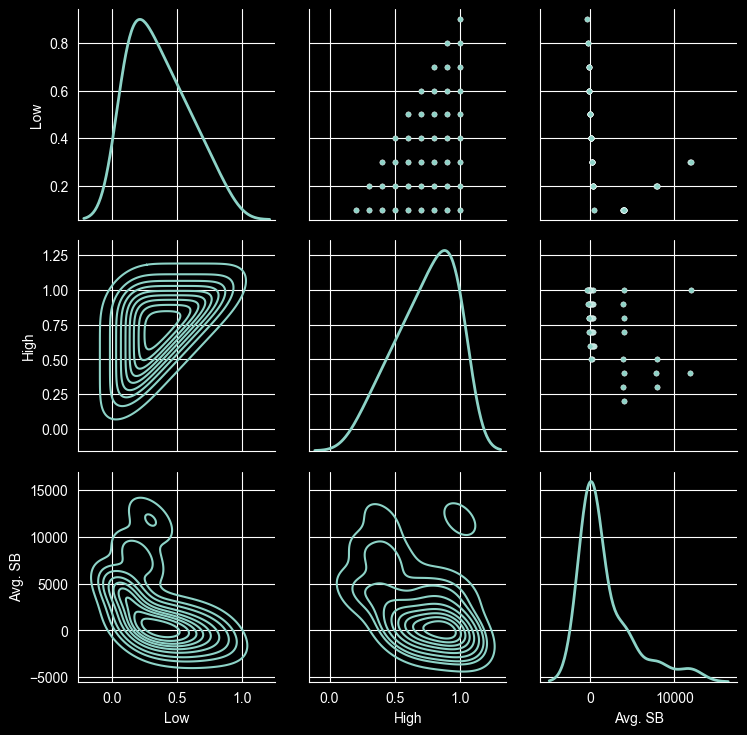

In [248]:
df = bindf[bindf['Line'] == .5][['Low', 'High', 'Avg. SB']]
g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)